In [ ]:
import pandas as pd
import numpy as np

column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
df = pd.read_csv(url, header=None, names=column_names, na_values='?')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


In [ ]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [ ]:
print("\nChecking Missing values")
print(df.isnull().sum())


Checking Missing values
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64


In [ ]:
for col in ['ca', 'thal']:
    df[col].fillna(df[col].mean(), inplace=True)

print(df.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


/tmp/ipython-input-915070549.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


In [ ]:
# Convert categorical columns to dummy variables
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

#target variable (0 = no disease, 1 = disease)
df['target'] = (df['target'] > 0).astype(int)

In [ ]:
from sklearn.preprocessing import StandardScaler

X = df.drop('target', axis=1)
y = df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

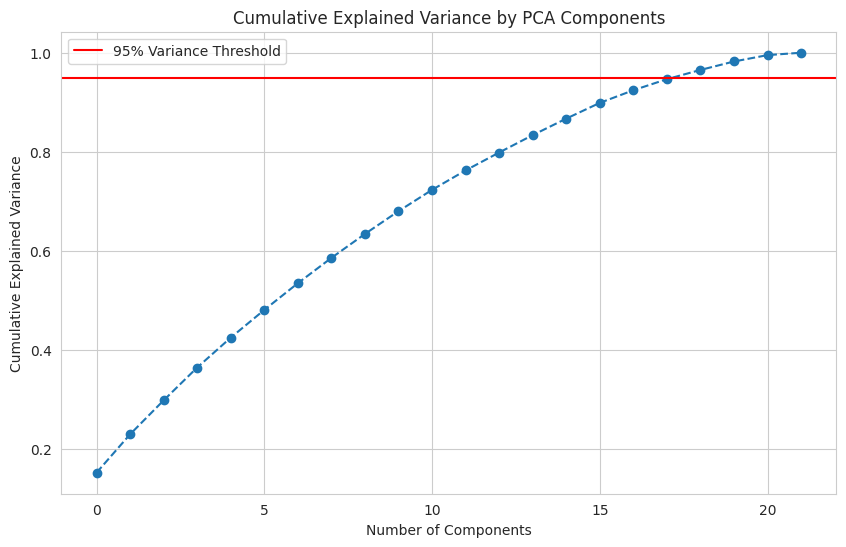


Original number of features: 22
Reduced number of features via PCA: 19


In [ ]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA().fit(X_scaled)

# Plot cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Variance Threshold')
plt.legend()
plt.show()

# Let's choose the number of components that explain ~95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"\nOriginal number of features: {X_scaled.shape[1]}")
print(f"Reduced number of features via PCA: {X_pca.shape[1]}")

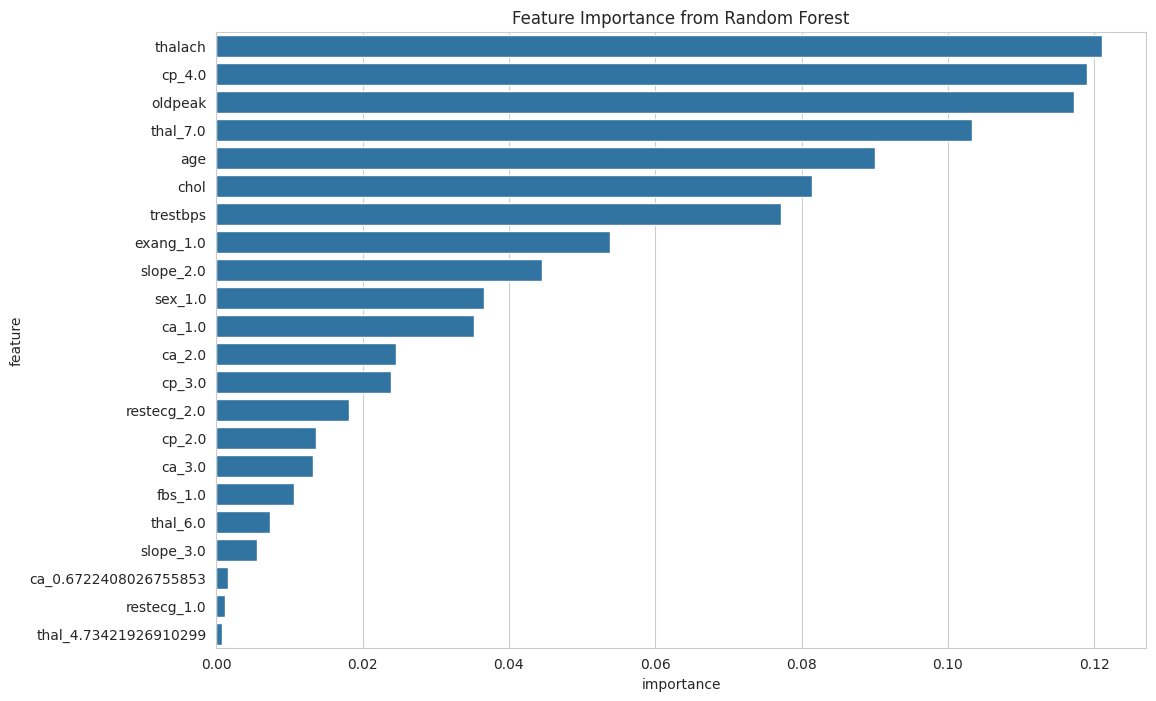


Top 10 selected features:
['thalach', 'cp_4.0', 'oldpeak', 'thal_7.0', 'age', 'chol', 'trestbps', 'exang_1.0', 'slope_2.0', 'sex_1.0']


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_fs = RandomForestClassifier(n_estimators=100, random_state=42)
model_fs.fit(X_scaled, y)

importances = pd.DataFrame({
    'feature': X_scaled.columns,
    'importance': model_fs.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importances)
plt.title('Feature Importance from Random Forest')
plt.show()

top_features = importances.head(10)['feature'].tolist()
X_selected = X_scaled[top_features]

print("\nTop 10 selected features:")
print(top_features)

--- Logistic Regression ---
Accuracy: 0.8033
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        29
           1       0.81      0.81      0.81        32

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61

--- Decision Tree ---
Accuracy: 0.7541
              precision    recall  f1-score   support

           0       0.77      0.69      0.73        29
           1       0.74      0.81      0.78        32

    accuracy                           0.75        61
   macro avg       0.76      0.75      0.75        61
weighted avg       0.76      0.75      0.75        61

--- Random Forest ---
Accuracy: 0.8033
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        29
           1       0.81      0.81      0.81        32

    accuracy                           0.80        61
   ma

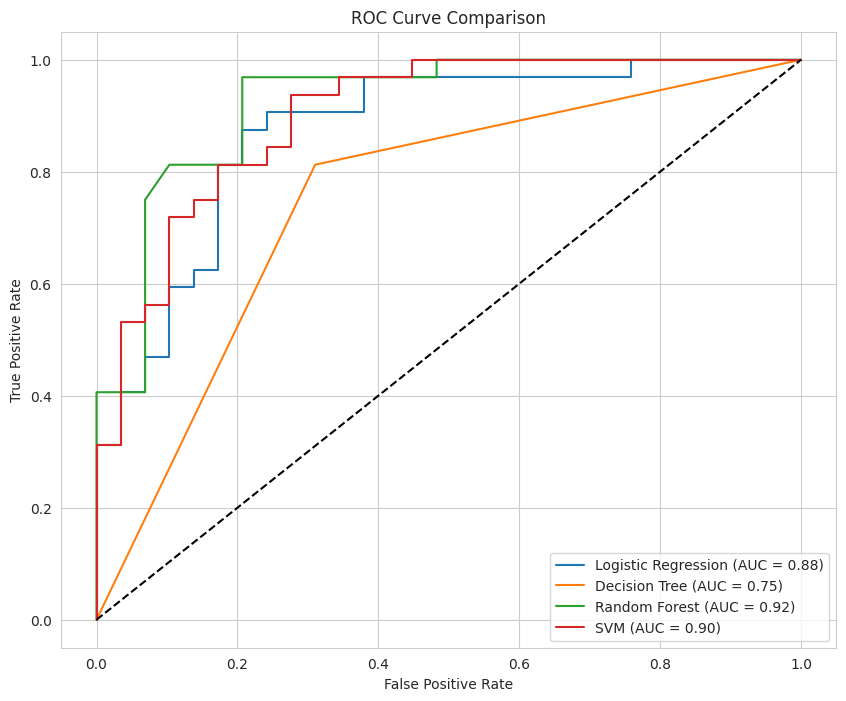

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42) # probability=True for ROC curve
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

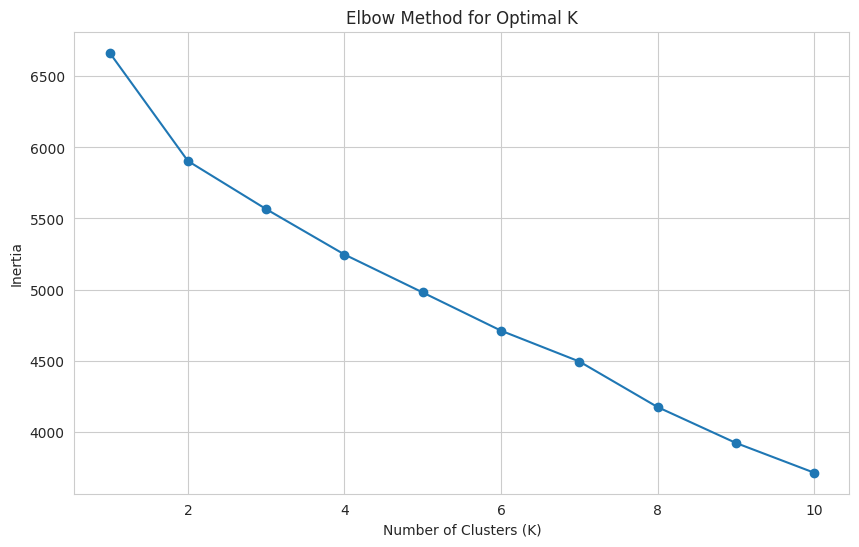

In [ ]:
from sklearn.cluster import KMeans

# Elbow Method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()
# From the plot, K=2 or K=3 seems optimal. Let's choose 2.

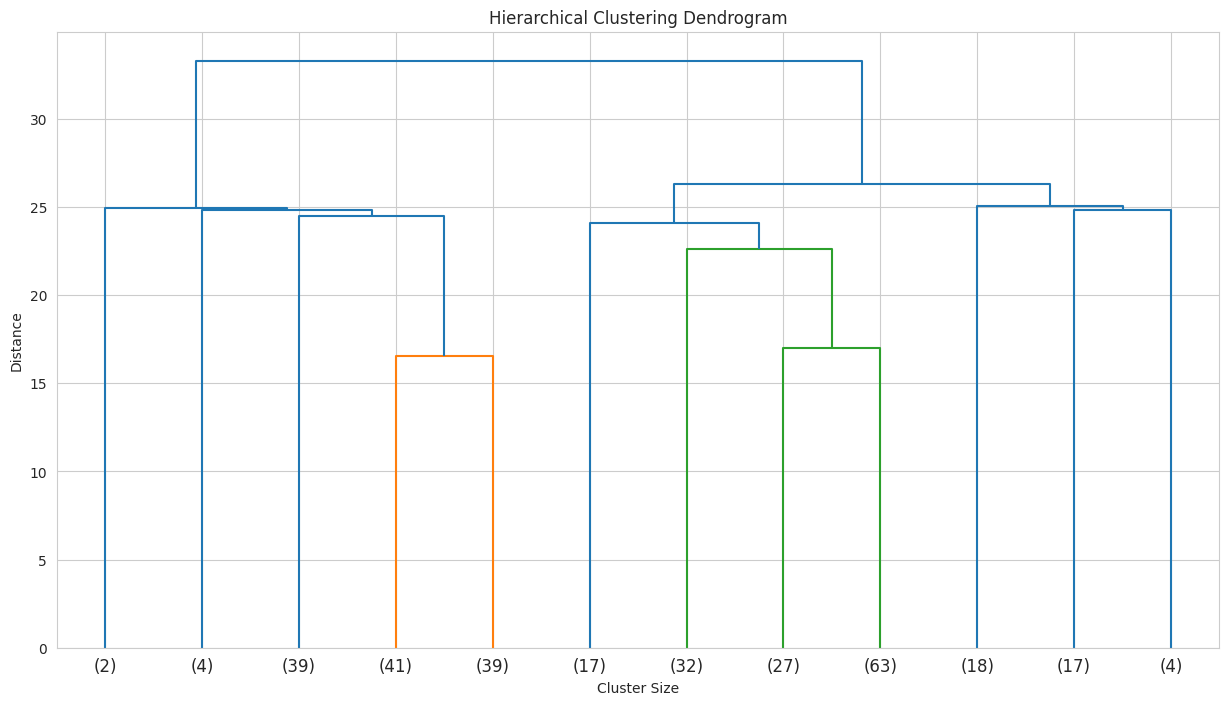

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Generate the linkage matrix
Z = linkage(X_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 8))
dendrogram(Z, truncate_mode='lastp', p=12)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters found: {grid_search.best_params_}")

best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
print("\n--- Tuned Random Forest Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

--- Tuned Random Forest Performance ---
Accuracy: 0.8197
              precision    recall  f1-score   support

           0       0.80      0.83      0.81        29
           1       0.84      0.81      0.83        32

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61



In [ ]:
import joblib

# Save the tuned model
joblib.dump(best_rf, 'heart_disease_model.pkl')

# Also save the scaler and selected features list
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(top_features, 'top_features.pkl')

print("\nModel, scaler, and feature list saved as .pkl files.")


Model, scaler, and feature list saved as .pkl files.


In [ ]:

joblib.dump(X_scaled.columns.tolist(), 'X_scaled_cols.pkl')

print("Column list saved successfully to X_scaled_cols.pkl")

Column list saved successfully to X_scaled_cols.pkl
